In [1]:
from ml_collections import ConfigDict
from pathlib import Path
from utils import get_classifier, get_data_config, get_dtype, load_checkpoint, prepare_test_dataset
from dataset_utils import get_dataloader, get_dataset
from jax import random
from models.utils import sample_gaussian

checkpoint_path = "gfz-50-epochs-a-1"
model_type = 'GFZ'

checkpoint = load_checkpoint(Path.cwd() / "checkpoints/modified/" / checkpoint_path)

config = ConfigDict(checkpoint["config"])

dtype = get_dtype(config.dtype)
test_key = random.PRNGKey(config.attack_seed)
classifier = get_classifier(config) 

test_ds = get_dataset(config.dataset, train=False)
train_ds = get_dataset(config.dataset, train=True)
dataset_config = get_data_config(test_ds)
test_images, test_labels = prepare_test_dataset(test_ds, dataset_config, dtype)

train_images, train_labels = prepare_test_dataset(train_ds, dataset_config, dtype)

test_dl = get_dataloader(test_ds, config.test_batch_size, dtype)

model_config = classifier.create_model_config(config)
log_likelihood_fn = classifier.log_likelihood_A
loss_fn = classifier.loss_A
trained_params = checkpoint["params"]

In [2]:
from flax import linen as nn
import jax
from jax import jacrev
import numpy as np
from functools import partial
from jax.scipy.special import logsumexp
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import softmax

def init_data(test_key, _type='test', n_samples=10):
    if _type == 'test':
        idx = np.random.choice(range(len(test_images)), n_samples, replace=False)
        all_xs = test_images[idx]
        true_ys = test_labels[idx]

    elif _type == 'train':
        idx = np.random.choice(range(len(train_images)), n_samples, replace=False)
        all_xs = train_images[idx]
        true_ys = train_labels[idx]

    true_labels = np.argmax(true_ys, axis=1)

    K = model_config.K
    batch_size = n_samples
    test_key, epsilons = sample_gaussian(test_key, (batch_size, model_config.n_classes * K, model_config.d_latent))
    epsilons = epsilons[:n_samples*model_config.n_classes]
    all_ys = nn.one_hot(jnp.repeat(jnp.arange(model_config.n_classes), K), model_config.n_classes, dtype=dtype)
    
    return all_xs, true_labels, epsilons, all_ys, K, test_key

def get_model_output(x, epsilon, y, K, no_grad=False):
    outputs = jax.vmap(
            partial(classifier.classifier(model_config).apply, {'params': trained_params}, train=False),
            in_axes=(None, 0, 0)
        )(x, y, epsilon)

    ll = log_likelihood_fn(*outputs).reshape(config.n_classes, K)
    ll = logsumexp(ll, axis=1) - np.log(K)
    return ll

def get_model_jacobian(x, epsilon, y, K):
    return jacrev(get_model_output, argnums=0)(x, epsilon, y, K, no_grad=False)

def map_label_to_name(y):
    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    return labels[y]

In [3]:
class DeepFool():
    def __init__(self, config, max_iter=10, learning_rate=1, p=2):
        self.config = config
        self.n_classes = config.n_classes
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        assert p > 1 
        self.p = p
        if self.p == np.inf:
            self.q = 1
        else:
            self.q = self.p/(self.p-1)

    def qnorm(self, x):
        return np.linalg.norm(x.flatten(), self.q)

    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon, self.y, self.K)
        return np.argmax(val)

    def get_likelihoods_and_gradients(self, x, epsilon):
        J = get_model_jacobian(x, epsilon, self.y, self.K)
        val = get_model_output(x, epsilon, self.y, self.K)
        return val, J

    def get_perturbation(self, x, epsilon, all_ys, K):
        corrupted_x = x.copy()
        self.y = all_ys
        self.K = K
        new_label = self.get_label(corrupted_x, epsilon)
        k = self.get_label(x, epsilon)
        for _ in range(self.max_iter):
            best_pert = np.inf
            likelihoods, gradients = self.get_likelihoods_and_gradients(corrupted_x, epsilon)
            for j in range(self.n_classes):
                if j != k:
                    w_j = gradients[j] - gradients[k]
                    f_j = likelihoods[j] - likelihoods[k]
                    pert = np.abs(f_j) / self.qnorm(w_j)
                    if pert < best_pert:
                        w = w_j
                        f = f_j
            r_i = (np.abs(f) / self.qnorm(w)**self.q) * (np.sign(w) * np.abs(w)**(self.q-1))
            corrupted_x = corrupted_x + self.learning_rate*r_i
            new_label = self.get_label(corrupted_x, epsilon)
            if new_label != k:
                break
        if new_label == k:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
        else:
            perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
        return corrupted_x, new_label, perturbation_norm

In [4]:
class FastGradientSign():
    def __init__(self, eta=0.3):
        self.eta = eta

    def get_likelihoods_and_gradients(self, x, epsilon):
        J = get_model_jacobian(x, epsilon, self.y, self.K)
        val = get_model_output(x, epsilon, self.y, self.K)
        return val, J
    
    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon, self.y, self.K)
        return np.argmax(val)

    def get_perturbation(self, x, epsilon, all_ys, K):
        corrupted_x = x.copy()  
        self.y = all_ys
        self.K = K
        original_label = self.get_label(x, epsilon)
        _, gradients = self.get_likelihoods_and_gradients(corrupted_x, epsilon)
        perturbations = np.array([self.eta * np.sign(g) for g in gradients])
        perturbated_labels = np.array([self.get_label(x+p, epsilon) for p in perturbations])
        different_labels_ids = np.where(perturbated_labels != original_label)
        if len(different_labels_ids[0]) == 0:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
            new_label = original_label
            smallest_perturbation = np.argmin(np.linalg.norm(perturbations, axis=0))
            corrupted_x = x + smallest_perturbation
        else:
            different_labels_norms = np.array([np.linalg.norm(p) for p in perturbations])[different_labels_ids]
            corrupted_x = x + perturbations[np.argmin(different_labels_norms)]
            new_label = self.get_label(corrupted_x, epsilon)
            perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
        return corrupted_x, new_label, perturbation_norm

In [5]:
# i = np.random.choice(range(n_samples))
# x = all_xs[i]
# true_label = true_labels[i]
# test_key, epsilons = sample_gaussian(test_key, (1, model_config.n_classes * K, model_config.d_latent))
# epsilon = epsilons[0]

# deepfool_model = DeepFool(config, learning_rate=0.2)
# corrupted_x_deepfool, new_label_deepfool, perturbation_norm_deepfool = deepfool_model.get_perturbation(x, epsilon, all_ys, K)

# fgs_model = FastGradientSign(eta=0.3)
# corrupted_x_fgs, new_label_fgs, perturbation_norm_fgs = fgs_model.get_perturbation(x, epsilon, all_ys, K)

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# axs[0].imshow(x.reshape(28, 28), cmap="gray")
# axs[0].set_title(f"Original image (label = '{map_label_to_name(true_label)}')")

# axs[1].imshow(corrupted_x_deepfool.reshape(28, 28), cmap="gray")
# axs[1].set_title(f"DeepFool perturbated image (label = '{map_label_to_name(new_label_deepfool)}')")

# axs[2].imshow(corrupted_x_fgs.reshape(28, 28), cmap="gray")
# axs[2].set_title(f"FGS perturbated image (label = '{map_label_to_name(new_label_fgs)}')")

# fig.suptitle(f"Comparison of DeepFool and Fast Gradient Sign on a random sample")
# plt.show()

In [6]:
def generate_p_bayes(corruption_model, n_samples, all_xs, epsilons, true_labels, all_ys, K, corruption=True):
    all_generated_p_bayes = np.zeros((n_samples, 10))
    well_classified = []
    for i in tqdm(range(n_samples)):
        x = all_xs[i]
        epsilon = epsilons[i]
        if corruption:
            corrupted_x, _, _ = corruption_model.get_perturbation(x, epsilon, all_ys, K)
        else:
            corrupted_x = x
        ll = get_model_output(corrupted_x, epsilon, all_ys, K)
        p_bayes = softmax(ll)
        if true_labels[i] == np.argmax(p_bayes):
            well_classified.append(i)
        all_generated_p_bayes[i] = p_bayes
    return all_generated_p_bayes, well_classified

def evaluate_treshold(alpha, all_generated_p_bayes, generated_predictions, all_true_p_bayes, true_predictions, well_classified, means, stds, n_samples):
    tresholds = means - alpha*stds

    detections = 0
    for i in range(n_samples):
        p_bayes = all_generated_p_bayes[i]
        if np.max(np.log(p_bayes)) < tresholds[generated_predictions[i]]:
            detections += 1
    detection_rate = detections/n_samples

    false_positives = 0
    for i in well_classified:
        p_bayes = all_true_p_bayes[i]
        if np.max(np.log(p_bayes)) < tresholds[true_predictions[i]]:
            false_positives += 1
    false_positive_rate = false_positives/len(well_classified)

    return detection_rate, false_positive_rate

def display_roc_curve(false_positives_list, detection_list, model_name, save=False):
    plt.plot(false_positives_list, detection_list)
    plt.xlabel("False positives")
    plt.ylabel("Detection rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(f"ROC curve - {model_name}")
    if save:
        plt.savefig(f"../latex/illustrations/ROC_{model_name}_{model_type}.png")
    plt.show()

In [7]:
def get_statistics(all_true_p_bayes, true_predictions, n_samples, n_classes):
    values = {i:[] for i in range(n_classes)}

    for i in range(n_samples):
        values[true_predictions[i]].append(all_true_p_bayes[i][true_predictions[i]])

    means = np.array([np.mean(np.log(values[i])) for i in range(n_classes)])
    stds = np.array([np.std(np.log(values[i])) for i in range(n_classes)])
    return means, stds

def get_detection_rate(test_key, corruption_model, model_name, n_samples, n_classes=10):
    ## sample from test set to generate perturbations 
    all_xs_test, true_labels_test, epsilons_test, all_ys_test, K_test, test_key = init_data(test_key, _type='test', n_samples=n_samples)
    ## sample from train set to estimate tresholds
    all_xs_train, true_labels_train, epsilons_train, all_ys_train, K_train, test_key = init_data(test_key, _type='train', n_samples=n_samples)

    ## generate p_bayes for test set
    all_generated_p_bayes, well_classified = generate_p_bayes(corruption_model, n_samples, all_xs_test, epsilons_test, true_labels_test, all_ys_test, K_test)
    generated_predictions = np.argmax(all_generated_p_bayes, axis=1)

    ## generate p_bayes for train set
    all_true_p_bayes, well_classified = generate_p_bayes(corruption_model, n_samples, all_xs_train, epsilons_train, true_labels_train, all_ys_train, K_train, corruption=False)
    true_predictions = np.argmax(all_true_p_bayes, axis=1)

    means, stds = get_statistics(all_true_p_bayes, true_predictions, n_samples, n_classes)

    ## construct ROC curve
    detection_list, false_positives_list = [], []
    for alpha in np.linspace(-2., 2, 100):
        detections, false_positives = evaluate_treshold(alpha,
        all_generated_p_bayes, generated_predictions,
        all_true_p_bayes, true_predictions,
        well_classified, means,
        stds, n_samples
        )
        detection_list.append(detections)
        false_positives_list.append(false_positives)

    false_positives_list = np.array(false_positives_list)
    detection_list = np.array(detection_list)

    display_roc_curve(false_positives_list, detection_list, model_name, save=True)
    detection_rate_5pc = detection_list[np.where(false_positives_list < 0.05)[0]].max()
    print(f'Detection rate for 5% false positives on train set: {100*detection_rate_5pc:.2f}% ({model_type} model)')
    return test_key, detection_rate_5pc

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:43<06:23,  4.22s/it]

 13%|█▎        | 13/100 [00:58<05:42,  3.94s/it]

 25%|██▌       | 25/100 [01:45<04:53,  3.92s/it]

 37%|███▋      | 37/100 [02:32<04:05,  3.89s/it]

 43%|████▎     | 43/100 [02:56<03:49,  4.04s/it]

 81%|████████  | 81/100 [05:26<01:12,  3.82s/it]

100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


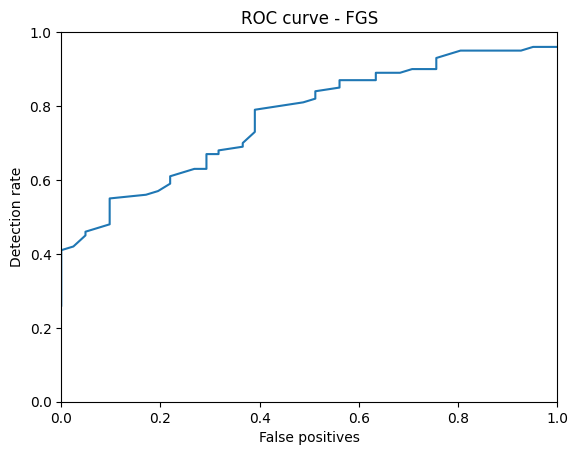

Detection rate for 5% false positives on train set: 46.00% (GFZ model)


 25%|██▌       | 25/100 [00:47<02:27,  1.97s/it]

 76%|███████▌  | 76/100 [02:39<01:13,  3.06s/it]

100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


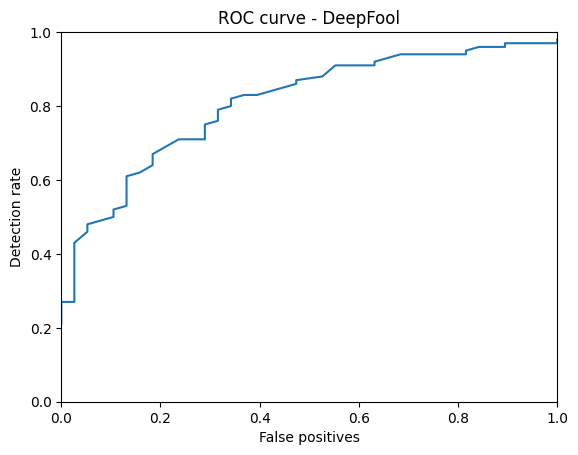

Detection rate for 5% false positives on train set: 43.00% (GFZ model)


In [8]:
corruption_model = FastGradientSign(eta=0.3)
model_name = "FGS"

test_key, detection_rate = get_detection_rate(test_key, corruption_model, model_name, n_samples=100, n_classes=config.n_classes)

corruption_model = DeepFool(config)
model_name = "DeepFool"

test_key, detection_rate = get_detection_rate(test_key, corruption_model, model_name, n_samples=100, n_classes=config.n_classes)